In [4]:
%load_ext autoreload

%autoreload 2
from astropy.io import fits as fits
import matplotlib.pyplot as plt
import pickle
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value


sys.path.append('../../modeling')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_COUNT_class_likelihood as likelihood
import CL_LENSING_cluster_lensing as cl_lensing

In [5]:
name = '../../data/matched_pairs_Mfofcut.fits'
dat = fits.open(name)
dat_open= dat[1].data

In [6]:
dat_open['cat1_id']

chararray(['10', '18', '24', ..., '97912', '37112', '74968'], dtype='<U11')

In [3]:
table = Table()
table['richness'] = dat_open['cat1_richness']
table['M200c'] = dat_open['cat2_M200c']
table['redshift'] = dat_open['cat1_ztrue_cg']

(array([5.4700e+03, 7.9260e+03, 1.0591e+04, 9.5280e+03, 5.3280e+03,
        1.9900e+03, 6.1500e+02, 1.5400e+02, 3.3000e+01, 3.0000e+00]),
 array([13.00010228, 13.22759224, 13.4550822 , 13.68257215, 13.91006211,
        14.13755207, 14.36504203, 14.59253199, 14.82002194, 15.0475119 ,
        15.27500186]),
 <BarContainer object of 10 artists>)

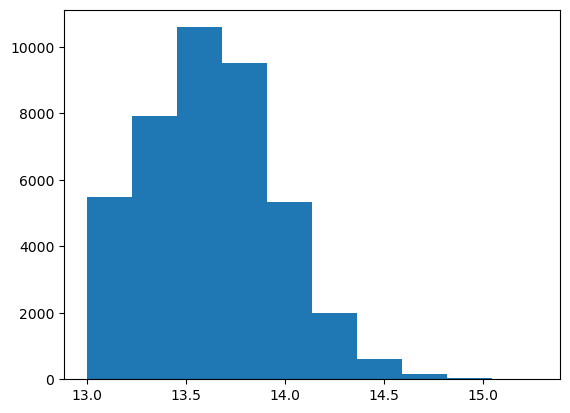

In [4]:
plt.hist(np.log10(table['M200c']))

In [5]:
richness_min = 10
table_cut = table[(table['M200c'] > 2e13)*(table['richness'] > richness_min)*(table['redshift'] < 1)*(table['redshift'] > .2)]

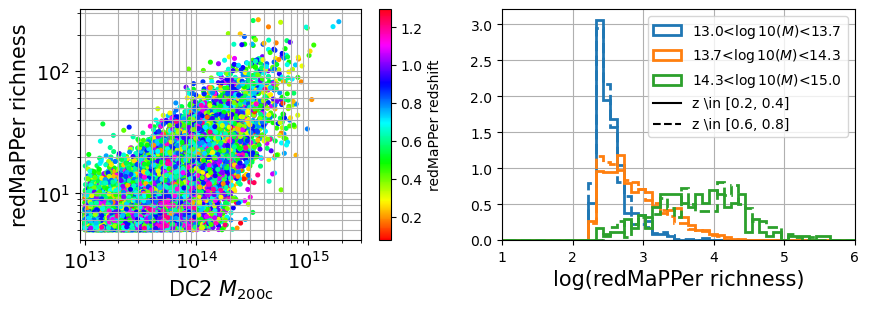

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.tick_params(axis='both', which = 'major', labelsize= 14)
plt.grid(True, which="both")
plt.scatter( table['M200c'], table['richness'],c=table['redshift'], s=7, cmap='hsv')
plt.xlim(9e12, 3e15)
plt.colorbar(label='redMaPPer redshift')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'redMaPPer richness', fontsize=15)
plt.xlabel(r'DC2 $M_{\rm 200c}$', fontsize=15)
plt.grid(True)
log_mass_index = np.linspace(13, 15, 4)
log_mass_bins = [[log_mass_index[i], log_mass_index [i+1]] for i in range(len(log_mass_index)-1)]
plt.subplot(122)
plt.xlabel(r'log(redMaPPer richness)', fontsize=15)
plt.grid(True, which="both")
bin_lambda = np.linspace(0, 10, 100)
color = ['C'+str(i) for i in range(20)]
for i, log_mass_bin in enumerate(log_mass_bins):
    mask_z_1 = (table_cut['redshift'] > 0.2)*(table_cut['redshift'] < 0.4)
    plt.hist(np.log(table_cut['richness'][(table_cut['M200c'] > 10**log_mass_bin[0])*(table_cut['M200c'] < 10**log_mass_bin[1])*mask_z_1]), 
             density=True, histtype='step', lw=2, label = f'{log_mass_bin[0]:.1f}<$\log10(M)$<{log_mass_bin[1]:.1f}', bins=bin_lambda,
            color = color[i])
    
    mask_z_2 = (table_cut['redshift'] > 0.6)*(table_cut['redshift'] < 0.8)
    plt.hist(np.log(table_cut['richness'][(table_cut['M200c'] > 10**log_mass_bin[0])*(table_cut['M200c'] < 10**log_mass_bin[1])*mask_z_2]), 
             density=True, histtype='step', lw=2,  bins=bin_lambda, ls='--',color = color[i])

plt.plot([],[], '-k', label='z \in [0.2, 0.4]')
plt.plot([],[], '--k', label='z \in [0.6, 0.8]')
plt.legend()
plt.xlim(1, 6)
plt.savefig('../../fig/match_redMaPPer_cosmoDC2_lens_catalog.png',bbox_inches='tight', dpi=300)

In [7]:
import scipy
u = np.linspace(-50, 50, 2000)
pu = 0.5*(1 + scipy.special.erf(u))
def p_f(x):
    return np.interp(x, u, pu, left=None, right=None)

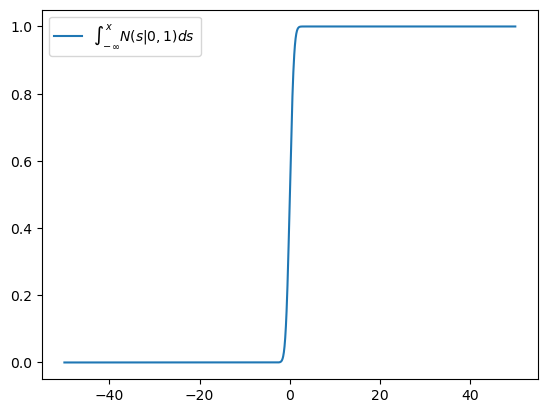

In [8]:
plt.plot(u, pu, label = r'$\int_{-\infty}^x N(s|0,1)ds$')
plt.legend(fontsize=10)

In [9]:
def lnLikelihood(p):
    proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m = p
    params = np.log10(10**14.3), .5, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m 
    mu = rm_relation.proxy_mu_f(np.log10(table_cut['M200c']), table_cut['redshift'],  params)
    sigma= rm_relation.proxy_sigma_f(np.log10(table_cut['M200c']), table_cut['redshift'],  params)
    pdf_lnlambda = table_cut['richness']*rm_relation.pdf_richness_mass_relation(table_cut['richness'], np.log10(table_cut['M200c']), table_cut['redshift'], params)
    normalx = np.array((np.log(richness_min) - mu)/(np.sqrt(2)*sigma))
    normalp =  p_f(normalx)
    pdf_lnlambda = pdf_lnlambda/(1-normalp)
    if np.isnan(np.sum(np.log(pdf_lnlambda))): return -np.inf
    return np.sum(np.log(pdf_lnlambda))

In [10]:
initial = [3.33413625, -0.01682437,  2.34084305,  0.56353637, -0.10364501,  0.00758468,]
lnLikelihood(initial)

-1992.6614459119505

In [11]:
from multiprocessing import Pool
nwalker=20
pos=.001*np.random.randn(nwalker,6) + initial
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalker, 6, lnLikelihood, pool=pool)
    sampler.run_mcmc(pos, 400, progress=True);
flat_samples1 = sampler.get_chain(discard=10, thin=3, flat=True)

100%|██████████| 400/400 [00:06<00:00, 63.70it/s]


[ 3.34197974  0.08931269  2.25997571  0.56014799 -0.05721073  0.05623336]


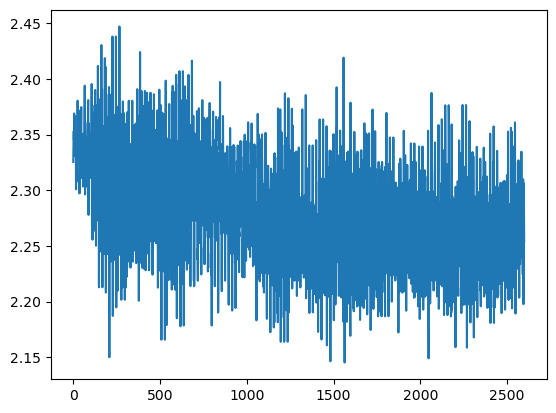

In [12]:
plt.plot(flat_samples1[:,2])
print(np.mean(flat_samples1[2000:], axis=0))
np.save('fiducial.pkl',flat_samples1[2000:],)

In [13]:
p = np.mean(flat_samples1[2000:], axis=0)
params = [np.log10(10**14.3), .5]
params = params + list(p)

(1.6094379124341003, 6.0)

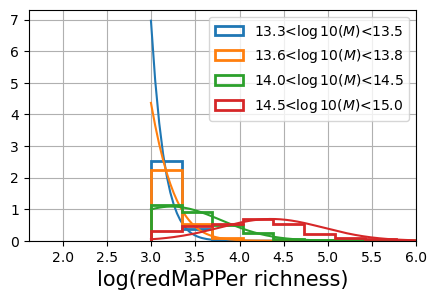

In [20]:
plt.figure(figsize=(5,3))
plt.xlabel(r'log(redMaPPer richness)', fontsize=15)
plt.grid(True, which="both")
bin_lambda = np.linspace(np.log(20), 20, 50)
bin_lambda_mid = [(bin_lambda[i]+bin_lambda[i+1])/2 for i in range(len(bin_lambda)-1)]
color = ['C'+str(i) for i in range(20)]
richness = np.linspace(20, 1000, 1000)
log_mass_index = [np.log10(2e13),  13.4, 13.8, 14, 14.1,]

log_mass_bins = [[np.log10(2e13),  13.5], [13.6,  13.8], [14,  14.5],  [14.5,  15]]
for i, log_mass_bin in enumerate(log_mass_bins):
    
    mean_log_mass = np.mean(log_mass_bin)
    mean_z = 0.5
    mask_z_1 = (table_cut['redshift'] > 0.2)*(table_cut['redshift'] < .8)
    
    #model
    mu = rm_relation.proxy_mu_f(mean_log_mass, mean_z,   params)
    sigma = rm_relation.proxy_sigma_f(mean_log_mass, mean_z,params)
    pdf_lnlambda = richness*rm_relation.pdf_richness_mass_relation(richness, mean_log_mass, mean_z, params)
    normalx = np.array((np.log(richness_min) - mu)/(np.sqrt(2)*sigma))
    normalp =  p_f(normalx)
    pdf_lnlambda = pdf_lnlambda/(1-normalp)
    #
    mask = (table_cut['M200c'] > 10**log_mass_bin[0]) * (table_cut['M200c'] < 10**log_mass_bin[1]) * mask_z_1
    a=plt.hist(np.log(table_cut['richness'][mask]), 
     histtype='step', lw=2, label = f'{log_mass_bin[0]:.1f}<'+r'$\log10(M)$'+f'<{log_mass_bin[1]:.1f}', bins=bin_lambda,
            color = color[i], density=True)
    #count = np.histogram(np.log(table_cut['richness'][mask]), bins=bin_lambda,)
    #print(count[0].shape)
    
    #plt.errorbar(bin_lambda_mid, count[0]/np.sum(count[0]*(bin_lambda[1]-bin_lambda[0])),
    #             count[0]**.5/np.sum(count[0]*(bin_lambda[1]-bin_lambda[0])),label = f'{log_mass_bin[0]:.1f}<'+r'$\log10(M)$'+f'<{log_mass_bin[1]:.1f}',
                 
                 #color = color[i],)
    plt.plot(np.log(richness), pdf_lnlambda/np.trapz(pdf_lnlambda, np.log(richness)))
    
plt.legend()
#plt.yscale('log')
plt.xlim(np.log(5), 6)

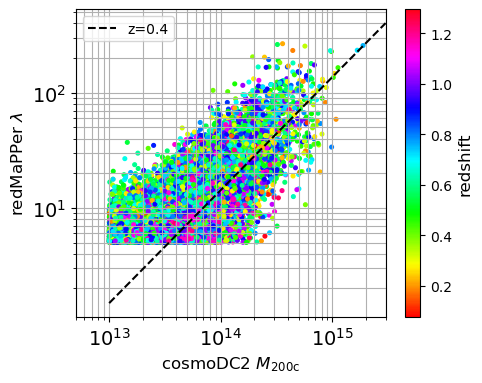

In [ ]:
plt.figure(figsize=(5,4))
plt.tick_params(axis='both', which = 'major', labelsize= 14)
plt.scatter( table['M200c'], np.exp(np.log(table['richness'])),c=table['redshift'], s=7, cmap='hsv')
m = np.linspace(1e13, 3e15, 10)
mu = rm_relation.proxy_mu_f(np.log10(m) , .4,  params,)
sigma = rm_relation.proxy_sigma_f(np.log10(m) , .4,  params,)
plt.plot(m, np.exp(mu) , '--k',label = 'z=0.4')
plt.colorbar().set_label(label=r'redshift',size=12,)
plt.xlim(5e12, 3e15)
plt.legend()
plt.grid(which='both')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'redMaPPer $\lambda$', fontsize=12)
plt.xlabel(r'cosmoDC2 $M_{\rm 200c}$', fontsize=12)
plt.savefig(f'../fig/fiducial_relation_scatter.png', dpi = 300,bbox_inches='tight',)